In [1]:
import healpy as hp
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
dist=0.8452888293408316
from all_p import gen_patches_pixels, gen_centers_fast

In [2]:
planck = pd.read_csv('../../src_data/planck_z.csv', index_col='index')
planck.head()

,Name,RAdeg,DEdeg,z,MSZ,MCXC,RedMAPPer,pix,theta,phi
index,,,,,,,,,,
0,PSZ2 G000.04+45.13,229.190512,-1.017222,0.1198,3.962411,J1516.5-0056,RMJ151653.9-010506.3,2,0.000708,0.787757
1,PSZ2 G000.13+78.04,203.558683,20.255990,0.1710,5.122391,J1334.1+2013,RMJ133408.7+201453.0,3,0.002410,1.362092
2,PSZ2 G000.40-41.86,316.084485,-41.354169,0.1651,5.297053,J2104.3-4120,,34,0.007034,-0.730609
3,PSZ2 G000.77-35.69,307.972844,-40.598725,0.3416,6.333562,J2031.8-4037,,16,0.013527,-0.623072
4,PSZ2 G002.08-68.28,349.632431,-36.332559,0.1400,2.835297,,,32,0.036425,-1.191738


In [3]:
this_pix = 6

In [4]:
planck_pix = planck.loc[planck['pix'] == this_pix]

In [5]:
planck_pix.index = np.arange(planck_pix.shape[0])

In [6]:
planck_pix.head()

,Name,RAdeg,DEdeg,z,MSZ,MCXC,RedMAPPer,pix,theta,phi
0,PSZ2 G094.56+51.03,227.061350,57.891783,0.539200,5.867250,,RMJ150822.0+575515.2,6,1.650529,0.890646
1,PSZ2 G095.29+44.13,238.134593,62.054477,0.330785,4.034956,,,6,1.663173,0.770246
2,PSZ2 G096.14+56.24,218.838751,55.141350,0.139773,2.771250,,RMJ143528.5+550752.3,6,1.678116,0.981694
3,PSZ2 G096.83+52.49,223.248775,58.036577,0.317900,4.924279,J1452.9+5802,,6,1.690171,0.916144
4,PSZ2 G097.15+39.20,246.903435,65.396317,0.205800,2.944873,,,6,1.695592,0.684326


In [36]:
all_pixels = gen_patches_pixels(planck_pix, dist / 2)

In [37]:
all_pixels = all_pixels.astype(np.int64)

In [38]:
sh = np.zeros(hp.nside2npix(2**10))
sh[all_pixels] = 1

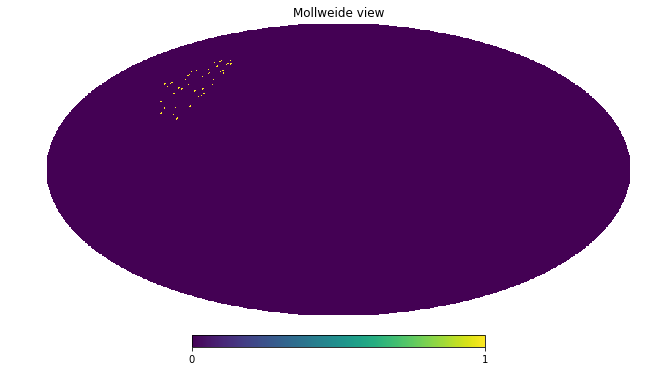

In [39]:
hp.mollview(sh, nest=True)

In [40]:
cnt = gen_centers_fast(5, all_pixels)

In [41]:
cnt

,pix,ra,dec
0,28951272106,227.238661,57.714167
1,28782830933,231.853772,62.074967
2,27245763242,172.656200,71.083684
3,29654129322,217.437934,56.954801
4,28951310336,227.238541,57.633491


In [42]:
from all_p import make_pic

In [43]:
mtx = make_pic(cnt['pix'].iloc[0], nside=2**17, size=2048)

In [44]:
def list_clusters(cat, ra, dec, patch_radius):
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    cat_sc = SkyCoord(ra=cat['RAdeg']*u.degree, dec=cat['DEdeg']*u.degree, frame='icrs')

    dists = sc.separation(cat_sc).degree
    clusters = cat.loc[dists < patch_radius]
    clusters.index = np.arange(clusters.shape[0])
    return clusters

In [45]:
clusters = list_clusters(planck, cnt['ra'].iloc[0], cnt['dec'].iloc[0], dist)


In [46]:
clusters

,Name,RAdeg,DEdeg,z,MSZ,MCXC,RedMAPPer,pix,theta,phi
0,PSZ2 G094.56+51.03,227.06135,57.891783,0.5392,5.86725,,RMJ150822.0+575515.2,6,1.650529,0.890646


In [47]:
from all_p import make_mask, pix2dict

In [48]:
dict_pix = pix2dict(mtx)

In [49]:
mask = make_mask(cnt['ra'].iloc[0], cnt['dec'].iloc[0], dict_pix, planck, cluster_radius=0.04, 
                 patch_radius=dist, nside=2**17, size=2048)

mask 1


In [50]:
import matplotlib.pyplot as plt

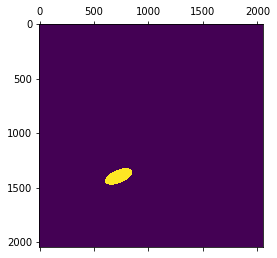

In [51]:
plt.matshow(mask)

In [52]:
from all_p import ClusterFile

In [53]:
cf = ClusterFile('_')

In [55]:
cf.params['typ'] = 'cen'
cf.params['num'] = 5
cf.params['inpix'] = this_pix
cf.params['size'] = dist
cf.params['id_list'] = 5
cf.file()

'tcen_il5_n5_in6_len0.8453'

In [57]:
cnt.index.name='index'

In [59]:
cnt.to_csv('/home/rt2122/data/check_cl/'+cf.file('.csv'))

In [60]:
def download_patches(filename, dirname, start=0):
    import pandas as pd
    from only_colab import get_patch
    from all_p import ClusterFile
    from os.path import join
    from tqdm import tqdm_notebook
    
    cnt = pd.read_csv(filename, index_col='index')
    cnt_cf = ClusterFile(filename)
    radius = cnt_cf.params['size']
    print('radius: %f' % radius)
    
    cf = ClusterFile('_')
    cf.params['typ'] = 'dat'
    cf.params['id_list'] = cnt_cf.params['id_list']
    cf.params['state'] = 'ne'
    cf.params['inpix'] = cnt_cf.params['inpix']
    for i in tqdm_notebook(range(start, cnt.shape[0])):
        ra = cnt['ra'].iloc[i]
        dec = cnt['dec'].iloc[i]
        cf.params['ra'] = ra
        cf.params['dec'] = dec
        cf.params['id_patch'] = i
        
        print('downloading to: %s'%join(dirname,cf.file('.csv')))
        get_patch(ra, dec, radius*60, job_name=str(i), file_name=join(dirname, cf.file('.csv')), 
                  table_name='table%d_%d' % (cnt_cf.params['id_list'], i))

In [61]:
dirname='/home/rt2122/data/check_cl/'
filename='/home/rt2122/data/check_cl/tcen_il5_n5_in6_len0.8453.csv'

In [63]:
download_patches(filename, dirname, 2)

radius: 0.845300


downloading to: /home/rt2122/data/check_cl/tdat_il5_ip2_ra172.6562_dec71.0837_sne_in6.csv
downloading to: /home/rt2122/data/check_cl/tdat_il5_ip3_ra217.4379_dec56.9548_sne_in6.csv
downloading to: /home/rt2122/data/check_cl/tdat_il5_ip4_ra227.2385_dec57.6335_sne_in6.csv


In [74]:
def all_mtx(cnt, dirname, this_list, this_pix):
    from os.path import join
    for i in range(cnt.shape[0]):
        pix = cnt['pix'].iloc[i]
        matrix = make_pic(pix, nside=2**17, size=2048)

        cf = ClusterFile('_')
        cf.params['typ'] = 'mtx'
        cf.params['id_list'] = this_list
        cf.params['id_patch'] = i
        cf.params['ra'] = cnt['ra'].iloc[i]
        cf.params['dec'] = cnt['dec'].iloc[i]
        cf.params['inpix'] = this_pix

        np.save(join(dirname, cf.file()), matrix)

In [65]:
from all_p import proc_files

In [66]:
from os import walk

In [69]:
files = next(walk('/home/rt2122/data/check_cl/'))[-1]
files = list(filter(lambda name:ClusterFile(name).params['typ']=='dat', files))
files

['tdat_il5_ip4_ra227.2385_dec57.6335_sne_in6.csv',
 'tdat_il5_ip3_ra217.4379_dec56.9548_sne_in6.csv',
 'tdat_il5_ip0_ra227.2387_dec57.7142_sne_in6.csv',
 'tdat_il5_ip1_ra231.8538_dec62.0750_sne_in6.csv',
 'tdat_il5_ip2_ra172.6562_dec71.0837_sne_in6.csv']

In [70]:
proc_files(files, '/home/rt2122/data/check_cl/', '/home/rt2122/data/check_cl/')

/home/rt2122/L/git/data-segmentation/rk/gen/all_p.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cur_duplicates = duplicates[duplicates["l"] == l][duplicates["b"] == b]


4 ) Removed: 426
tdat_il5_ip4_ra227.2385_dec57.6335_scl_in6.csv


3 ) Removed: 390
tdat_il5_ip3_ra217.4379_dec56.9548_scl_in6.csv


0 ) Removed: 425
tdat_il5_ip0_ra227.2387_dec57.7142_scl_in6.csv


1 ) Removed: 420
tdat_il5_ip1_ra231.8538_dec62.0750_scl_in6.csv


2 ) Removed: 407
tdat_il5_ip2_ra172.6562_dec71.0837_scl_in6.csv


In [75]:
all_mtx(cnt, '/home/rt2122/data/check_cl/', 5, 6)

In [80]:
mtx_dir = '/home/rt2122/data/check_cl'
mtx_files = next(walk(mtx_dir))[-1]
mtx_files = list(filter(lambda name:ClusterFile(name).params['typ']=='mtx', mtx_files))
mtx_files = sorted(mtx_files, key=lambda name:ClusterFile(name).params['id_patch'])
data_dir = '/home/rt2122/data/check_cl'
data_files = next(walk(data_dir))[-1]
data_files = list(filter(lambda name:ClusterFile(name).params['state']=='cl', data_files))
data_files = sorted(data_files, key=lambda name:ClusterFile(name).params['id_patch'])

In [88]:
def filters_files(data_files, mtx_files, data_dir, mtx_dir, filters_dir):
    from os.path import join
    from all_p import pic_all_filters
    for data, mtx in zip(data_files, mtx_files):
        print(data, mtx)
        #continue

        patch = pd.read_csv(join(data_dir, data), index_col='Unnamed: 0')
        patch.index.name = 'index'
        pic_matr = np.load(join(mtx_dir, mtx))

        dict_mtx = pix2dict(pic_matr)
        del pic_matr

        all_f = pic_all_filters(patch, dict_mtx, base=-4, size=2048)
        cf = ClusterFile(data)
        ra = cf.params['ra']
        dec = cf.params['dec']
        cf.params['typ'] = 'd'
        cf.params['state']='grizy'
        np.save(join(filters_dir, cf.file()), all_f)
        del all_f

        mask = make_mask(ra, dec, dict_mtx, planck_pix, patch_radius=dist, size=2048)
        mask *= 255
        cf.params['typ'] = 'm'
        cf.params['state'] = 'm'

        np.save(join(filters_dir, cf.file()), mask)

In [89]:
filters_files(data_files, mtx_files, data_dir, mtx_dir, '/home/rt2122/data/check_cl/')

tdat_il5_ip0_ra227.2387_dec57.7142_scl_in6.csv tmtx_il5_ip0_ra227.2387_dec57.7142_in6.npy


mask 1
tdat_il5_ip1_ra231.8538_dec62.0750_scl_in6.csv tmtx_il5_ip1_ra231.8538_dec62.0750_in6.npy


mask 1
tdat_il5_ip2_ra172.6562_dec71.0837_scl_in6.csv tmtx_il5_ip2_ra172.6562_dec71.0837_in6.npy


mask 1
tdat_il5_ip3_ra217.4379_dec56.9548_scl_in6.csv tmtx_il5_ip3_ra217.4379_dec56.9548_in6.npy


mask 1
tdat_il5_ip4_ra227.2385_dec57.6335_scl_in6.csv tmtx_il5_ip4_ra227.2385_dec57.6335_in6.npy


mask 1


In [110]:
def show_alot_pics(pics, h, w, hh, ww):
    import matplotlib.pyplot as plt
    from skimage.io import imshow
    fig = plt.figure(figsize=(hh, ww))
    
    for i in range(len(pics)):
        fig.add_subplot(h, w, i+1)
        pic = pics[i]
        plt.imshow(pic)

In [91]:
from os.path import join

In [130]:
mask_files = next(walk(mtx_dir))[-1]
mask_files = list(filter(lambda name:ClusterFile(name).params['state'] =='m', mask_files))
mask_files = sorted(mask_files, key=lambda name:ClusterFile(name).params['id_patch'])
mask_files

['tm_il5_ip0_ra227.2387_dec57.7142_sm_in6.npy',
 'tm_il5_ip1_ra231.8538_dec62.0750_sm_in6.npy',
 'tm_il5_ip2_ra172.6562_dec71.0837_sm_in6.npy',
 'tm_il5_ip3_ra217.4379_dec56.9548_sm_in6.npy',
 'tm_il5_ip4_ra227.2385_dec57.6335_sm_in6.npy']

In [131]:
masks = [np.load(join(mtx_dir, f), allow_pickle=True) for f in mask_files]

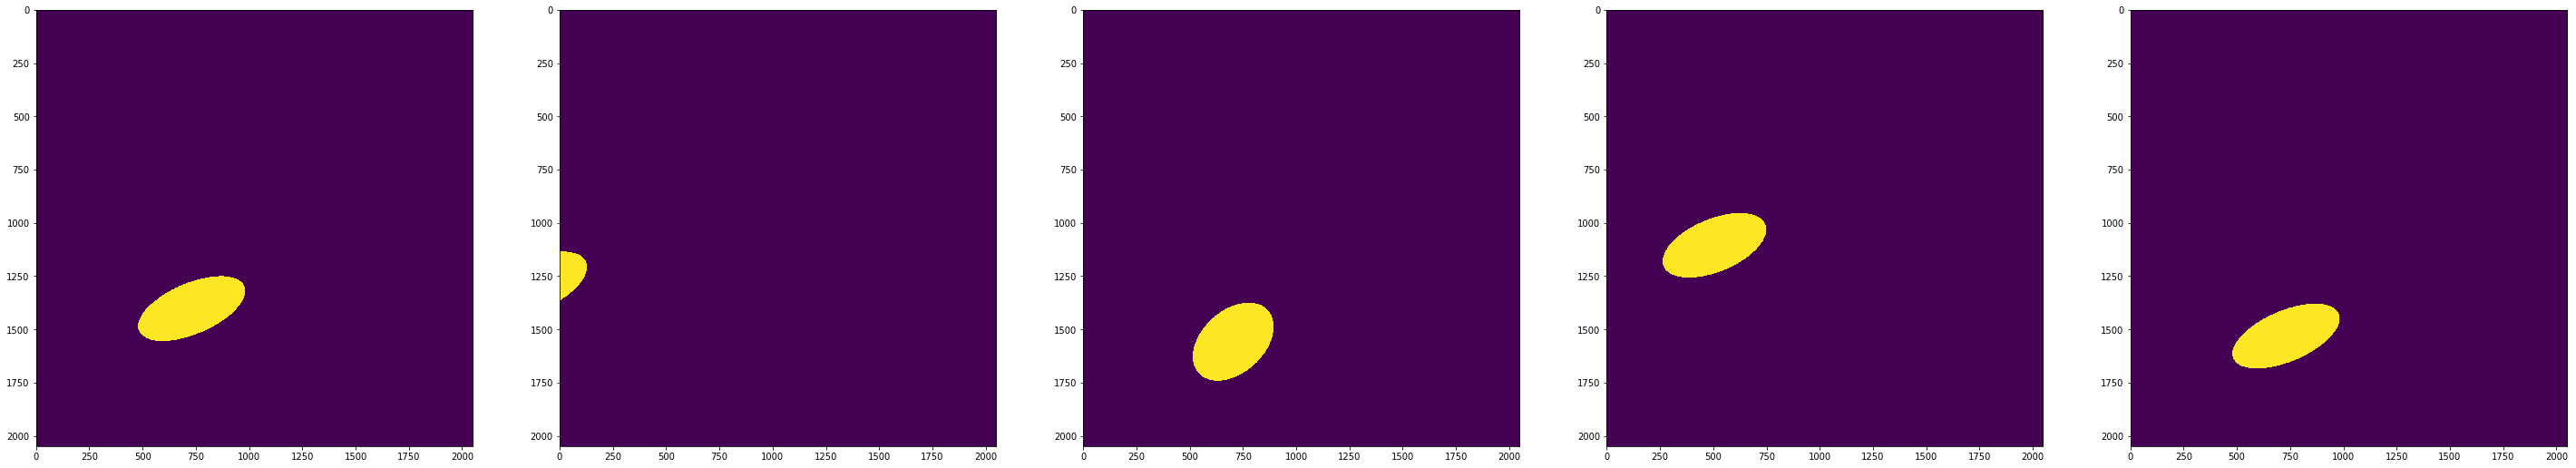

In [132]:
show_alot_pics(masks, 1, 5, 50, 10)

In [128]:
'dat' == 'm'

False

In [133]:
clusters = list_clusters(planck, cnt['ra'].iloc[1], cnt['dec'].iloc[1], dist)
clusters

,Name,RAdeg,DEdeg,z,MSZ,MCXC,RedMAPPer,pix,theta,phi
0,PSZ2 G097.78+46.95,231.052549,62.022709,0.3378,3.428005,,,6,1.706643,0.819539


In [135]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [139]:
sc = SkyCoord(ra=cnt['ra'].iloc[1]*u.degree, 
             dec=cnt['dec'].iloc[1]*u.degree, frame='icrs')
sc1 = SkyCoord(ra=clusters['RAdeg'].iloc[0]*u.degree,
              dec=clusters['DEdeg'].iloc[0]*u.degree, frame='icrs')
sc.separation(sc1).degree

0.3791642513096911

In [140]:
def pix_dist(nside, pix0, pix1):
    def dist(l, b, ll, bb):
        sc = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic')
        sscc = SkyCoord(l=ll*u.degree, b=bb*u.degree, frame='galactic')
        return sc.separation(sscc).degree
    
    l0, b0 = hp.pix2ang(nside=nside, ipix=pix0, nest=True, lonlat=True)
    l1, b1 = hp.pix2ang(nside=nside, ipix=pix1, nest=True, lonlat=True)
    
    return dist(l0, b0, l1, b1)

In [141]:
mtx = np.load('/home/rt2122/data/check_cl/tmtx_il5_ip0_ra227.2387_dec57.7142_in6.npy')

In [142]:
cen_pix = cnt['pix'].iloc[0]

In [143]:
min_dist = dist
min_dist

0.8452888293408316

In [146]:
from tqdm import tqdm_notebook

In [147]:
for i in tqdm_notebook(range(2048)):
    d0 = pix_dist(2**17, cen_pix, mtx[i, 0])
    d1 = pix_dist(2**17, cen_pix, mtx[i, 2047]) 
    d2 = pix_dist(2**17, cen_pix, mtx[0, i])
    d3 = pix_dist(2**17, cen_pix, mtx[2047, i])
    
    min_dist = min(min_dist, d0, d1, d2, d3)

In [148]:
min_dist

0.3248946326045941

In [174]:
data0 = np.load('/home/rt2122/data/check_cl/td_il5_ip0_ra227.2387_dec57.7142_sgrizy_in6.npy')

In [150]:
data0_list = [data0[:,:,i] for i in range(5)]

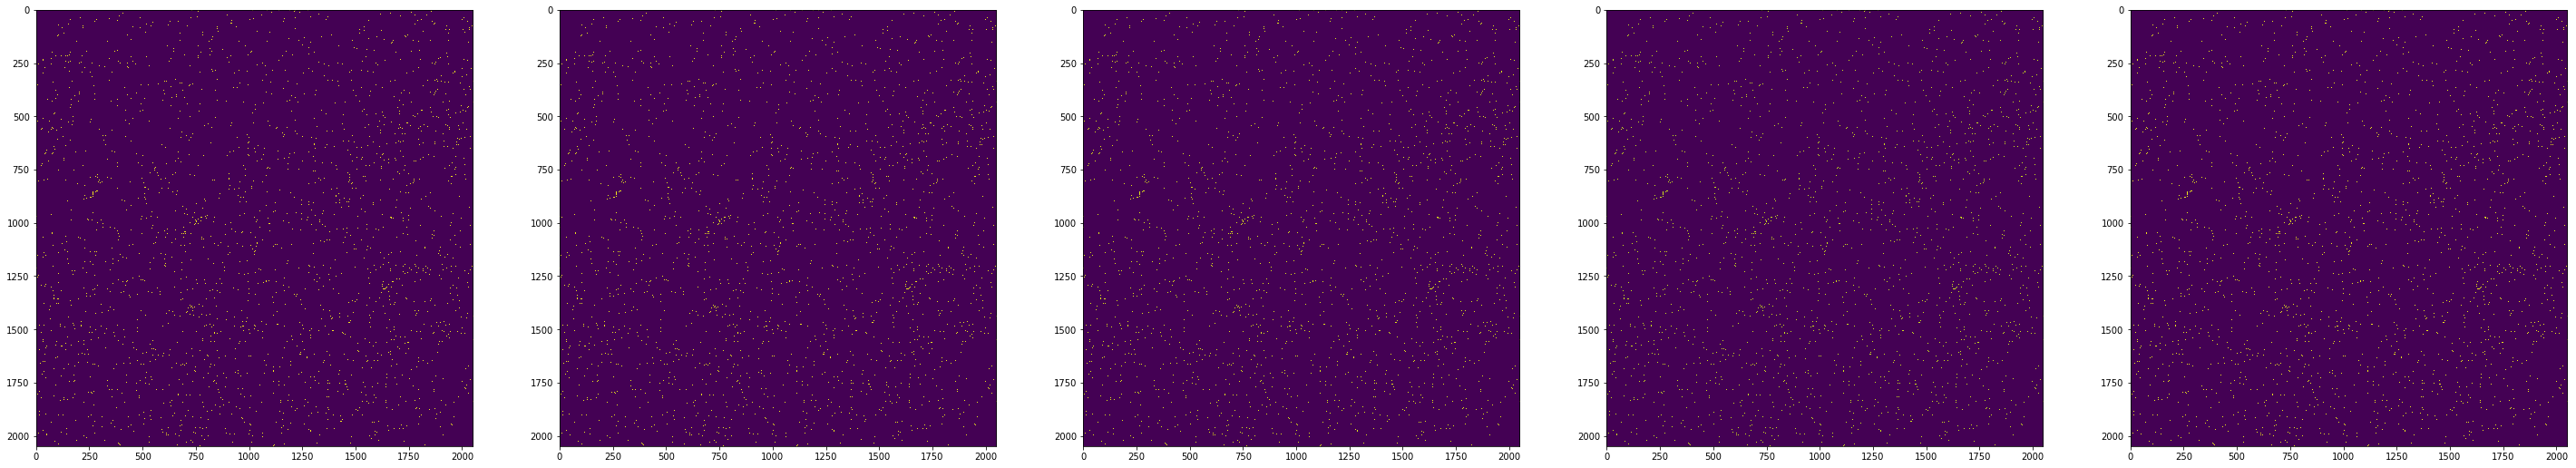

In [151]:
show_alot_pics(data0_list, 1, 5, 50, 10)

In [152]:
mask0.max()

255

In [154]:
mask0 //= 255

In [160]:
mask0 = mask0.reshape(list(mask0.shape) + [1])

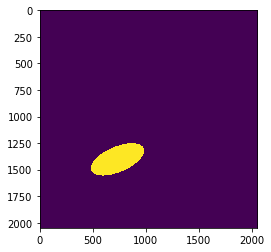

In [162]:
plt.imshow(mask0[:,:,0])

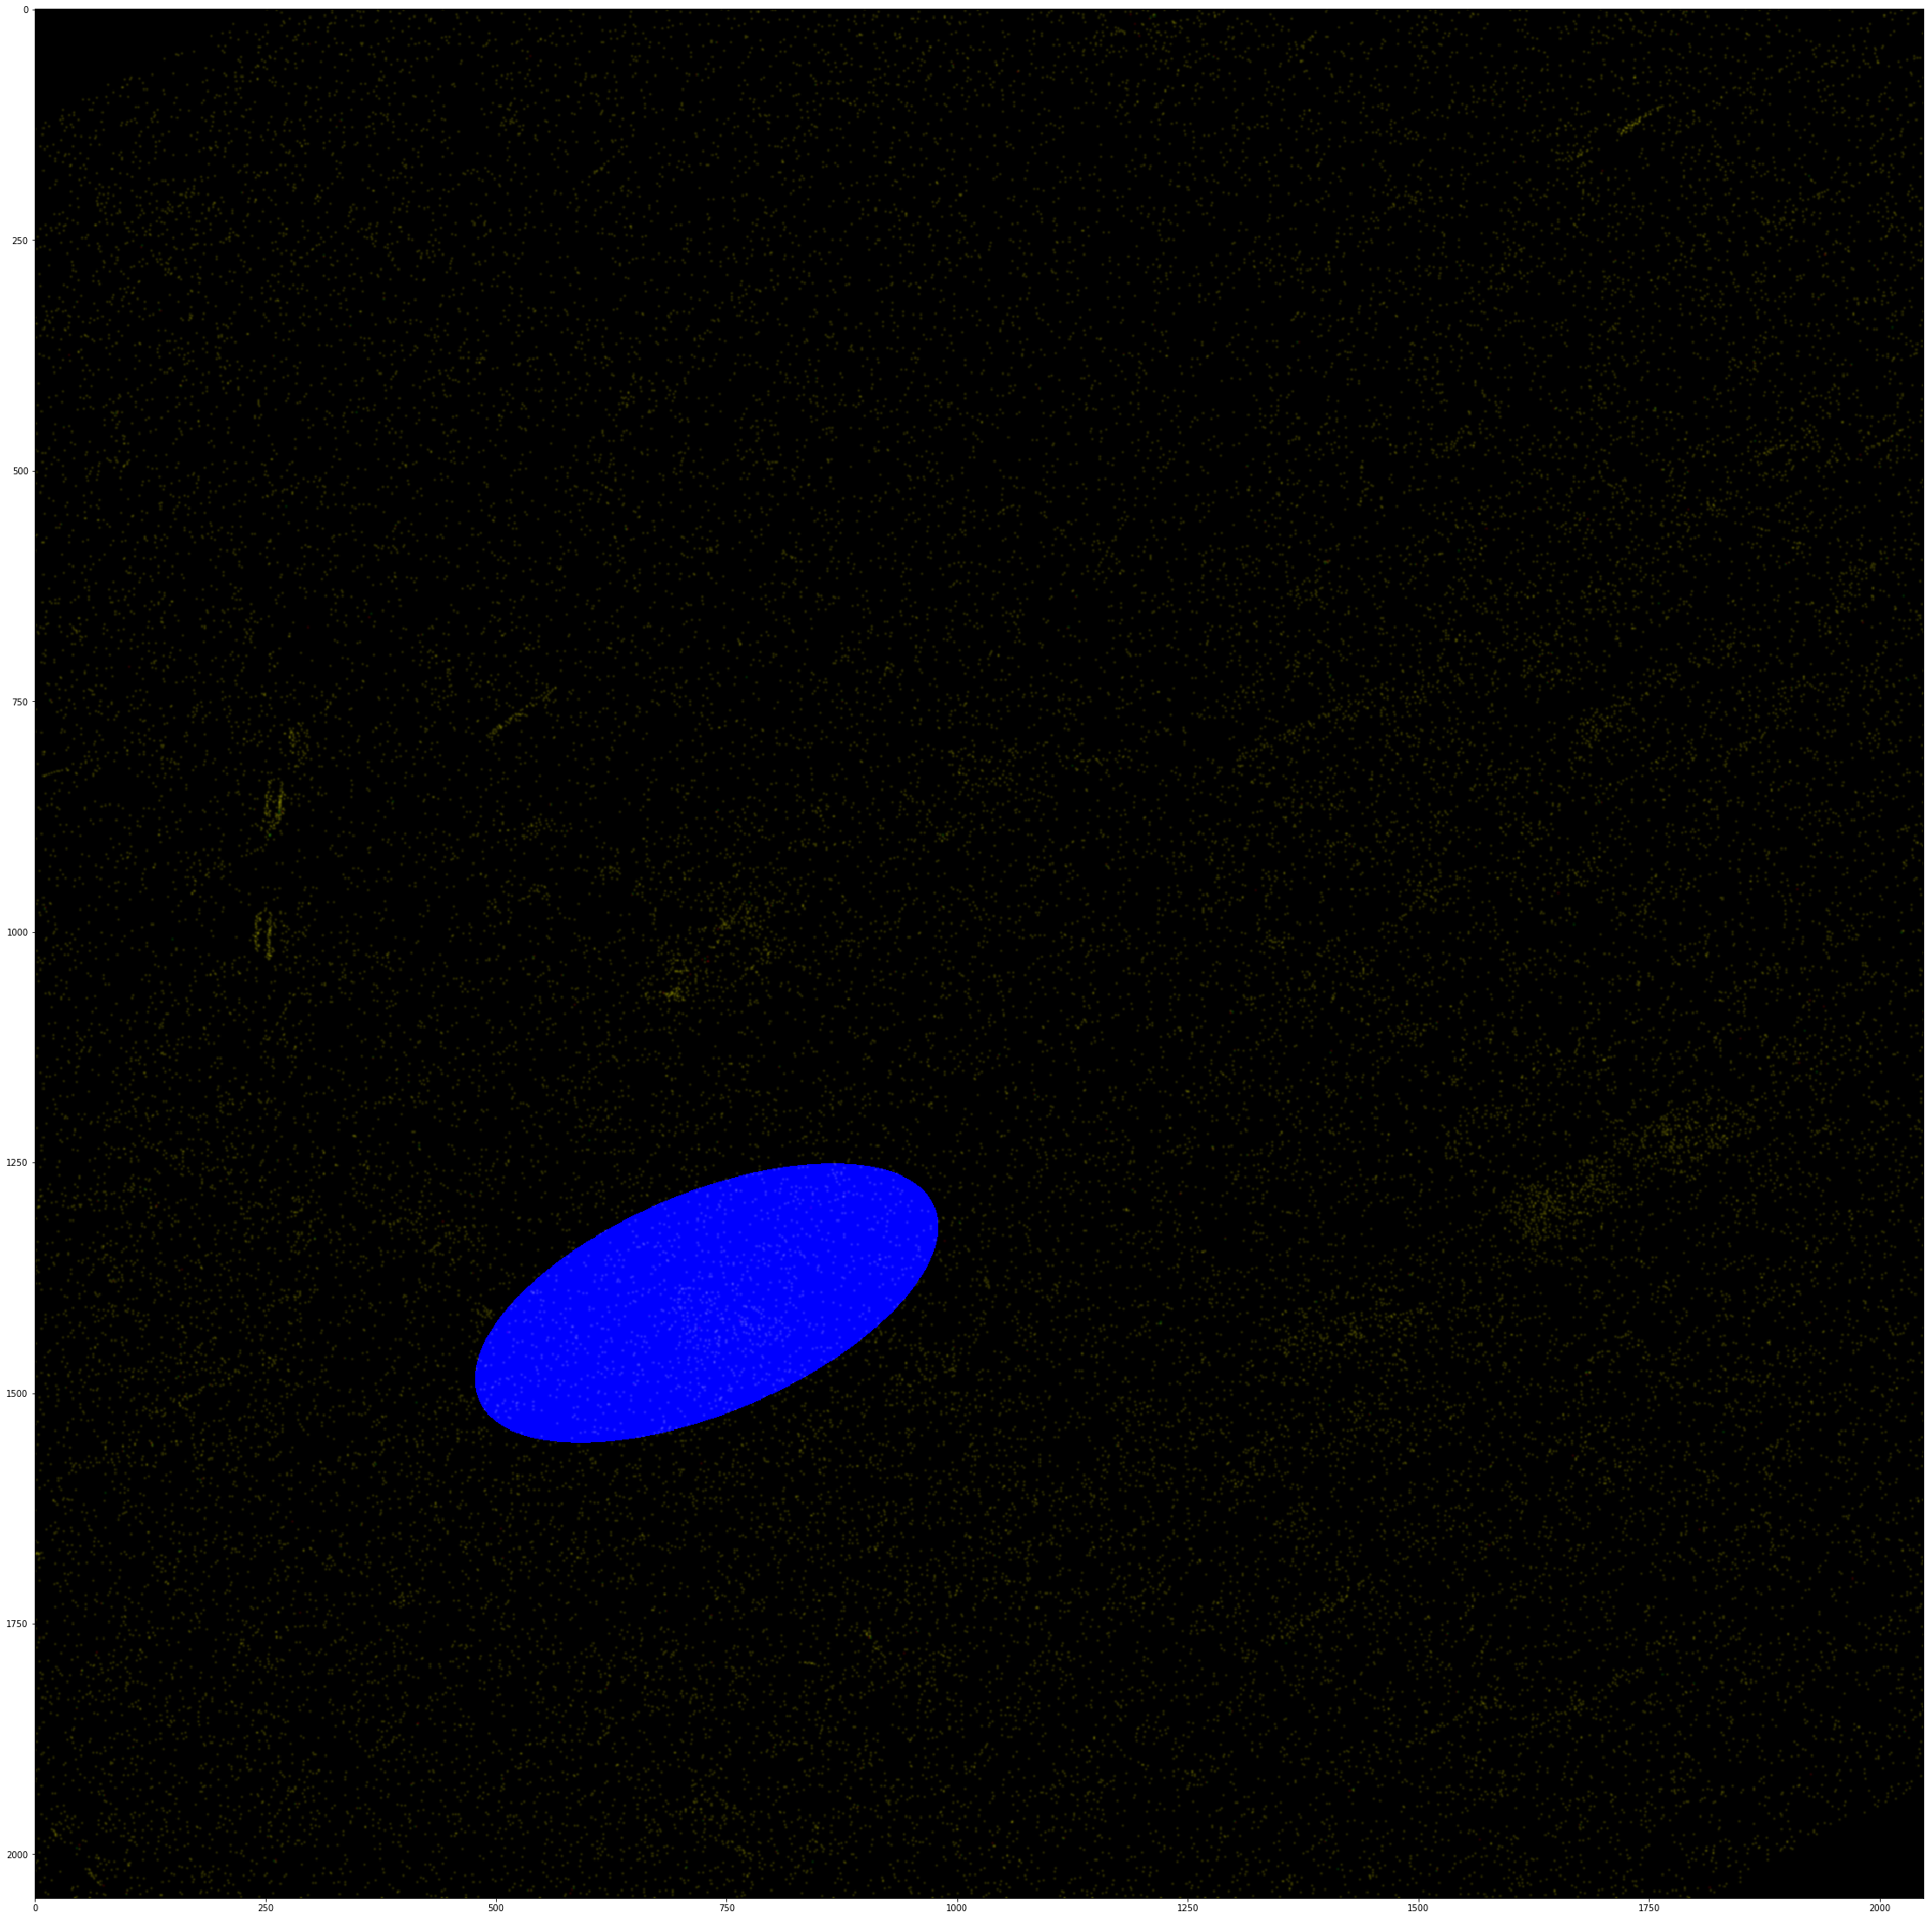

In [214]:
plt.figure(figsize=(40,40))
plt.imshow(np.dstack([data_nrm[:,:,0:2], mask0]))

In [158]:
data0.shape, mask0.shape

((2048, 2048, 5), (2048, 2048))

In [165]:
data0.max(), data0.min()

(0.307273, -4.0)

In [213]:
for i in range(5):
    data0[:,:,i] -=data0[:,:,i].min()
    data0[:,:,i] /= data0[:,:,i].max()

In [169]:
cnt

,pix,ra,dec
index,,,
0,28951272106,227.238661,57.714167
1,28782830933,231.853772,62.074967
2,27245763242,172.656200,71.083684
3,29654129322,217.437934,56.954801
4,28951310336,227.238541,57.633491


In [170]:
mask0 = np.load('/home/rt2122/data/check_cl/tm_il5_ip0_ra227.2387_dec57.7142_sm_in6.npy')

In [172]:
clusters = list_clusters(planck, cnt['ra'].iloc[0], cnt['dec'].iloc[0], dist)

In [173]:
clusters

,Name,RAdeg,DEdeg,z,MSZ,MCXC,RedMAPPer,pix,theta,phi
0,PSZ2 G094.56+51.03,227.06135,57.891783,0.5392,5.86725,,RMJ150822.0+575515.2,6,1.650529,0.890646


In [176]:
data0[data0 == -4] = 0

In [177]:
data0.min()

-0.0577252

In [232]:
data_nrm = np.copy(data0)

In [234]:
for i in range(5):
    data_nrm[:,:,i] -= data_nrm[:,:,i].min()
    data_nrm[:,:,i] /= data_nrm[:,:,i].max()


In [183]:
mask0.max()

255

In [185]:
mask0 //=255

In [233]:
data_nrm[data_nrm == 0] = -4

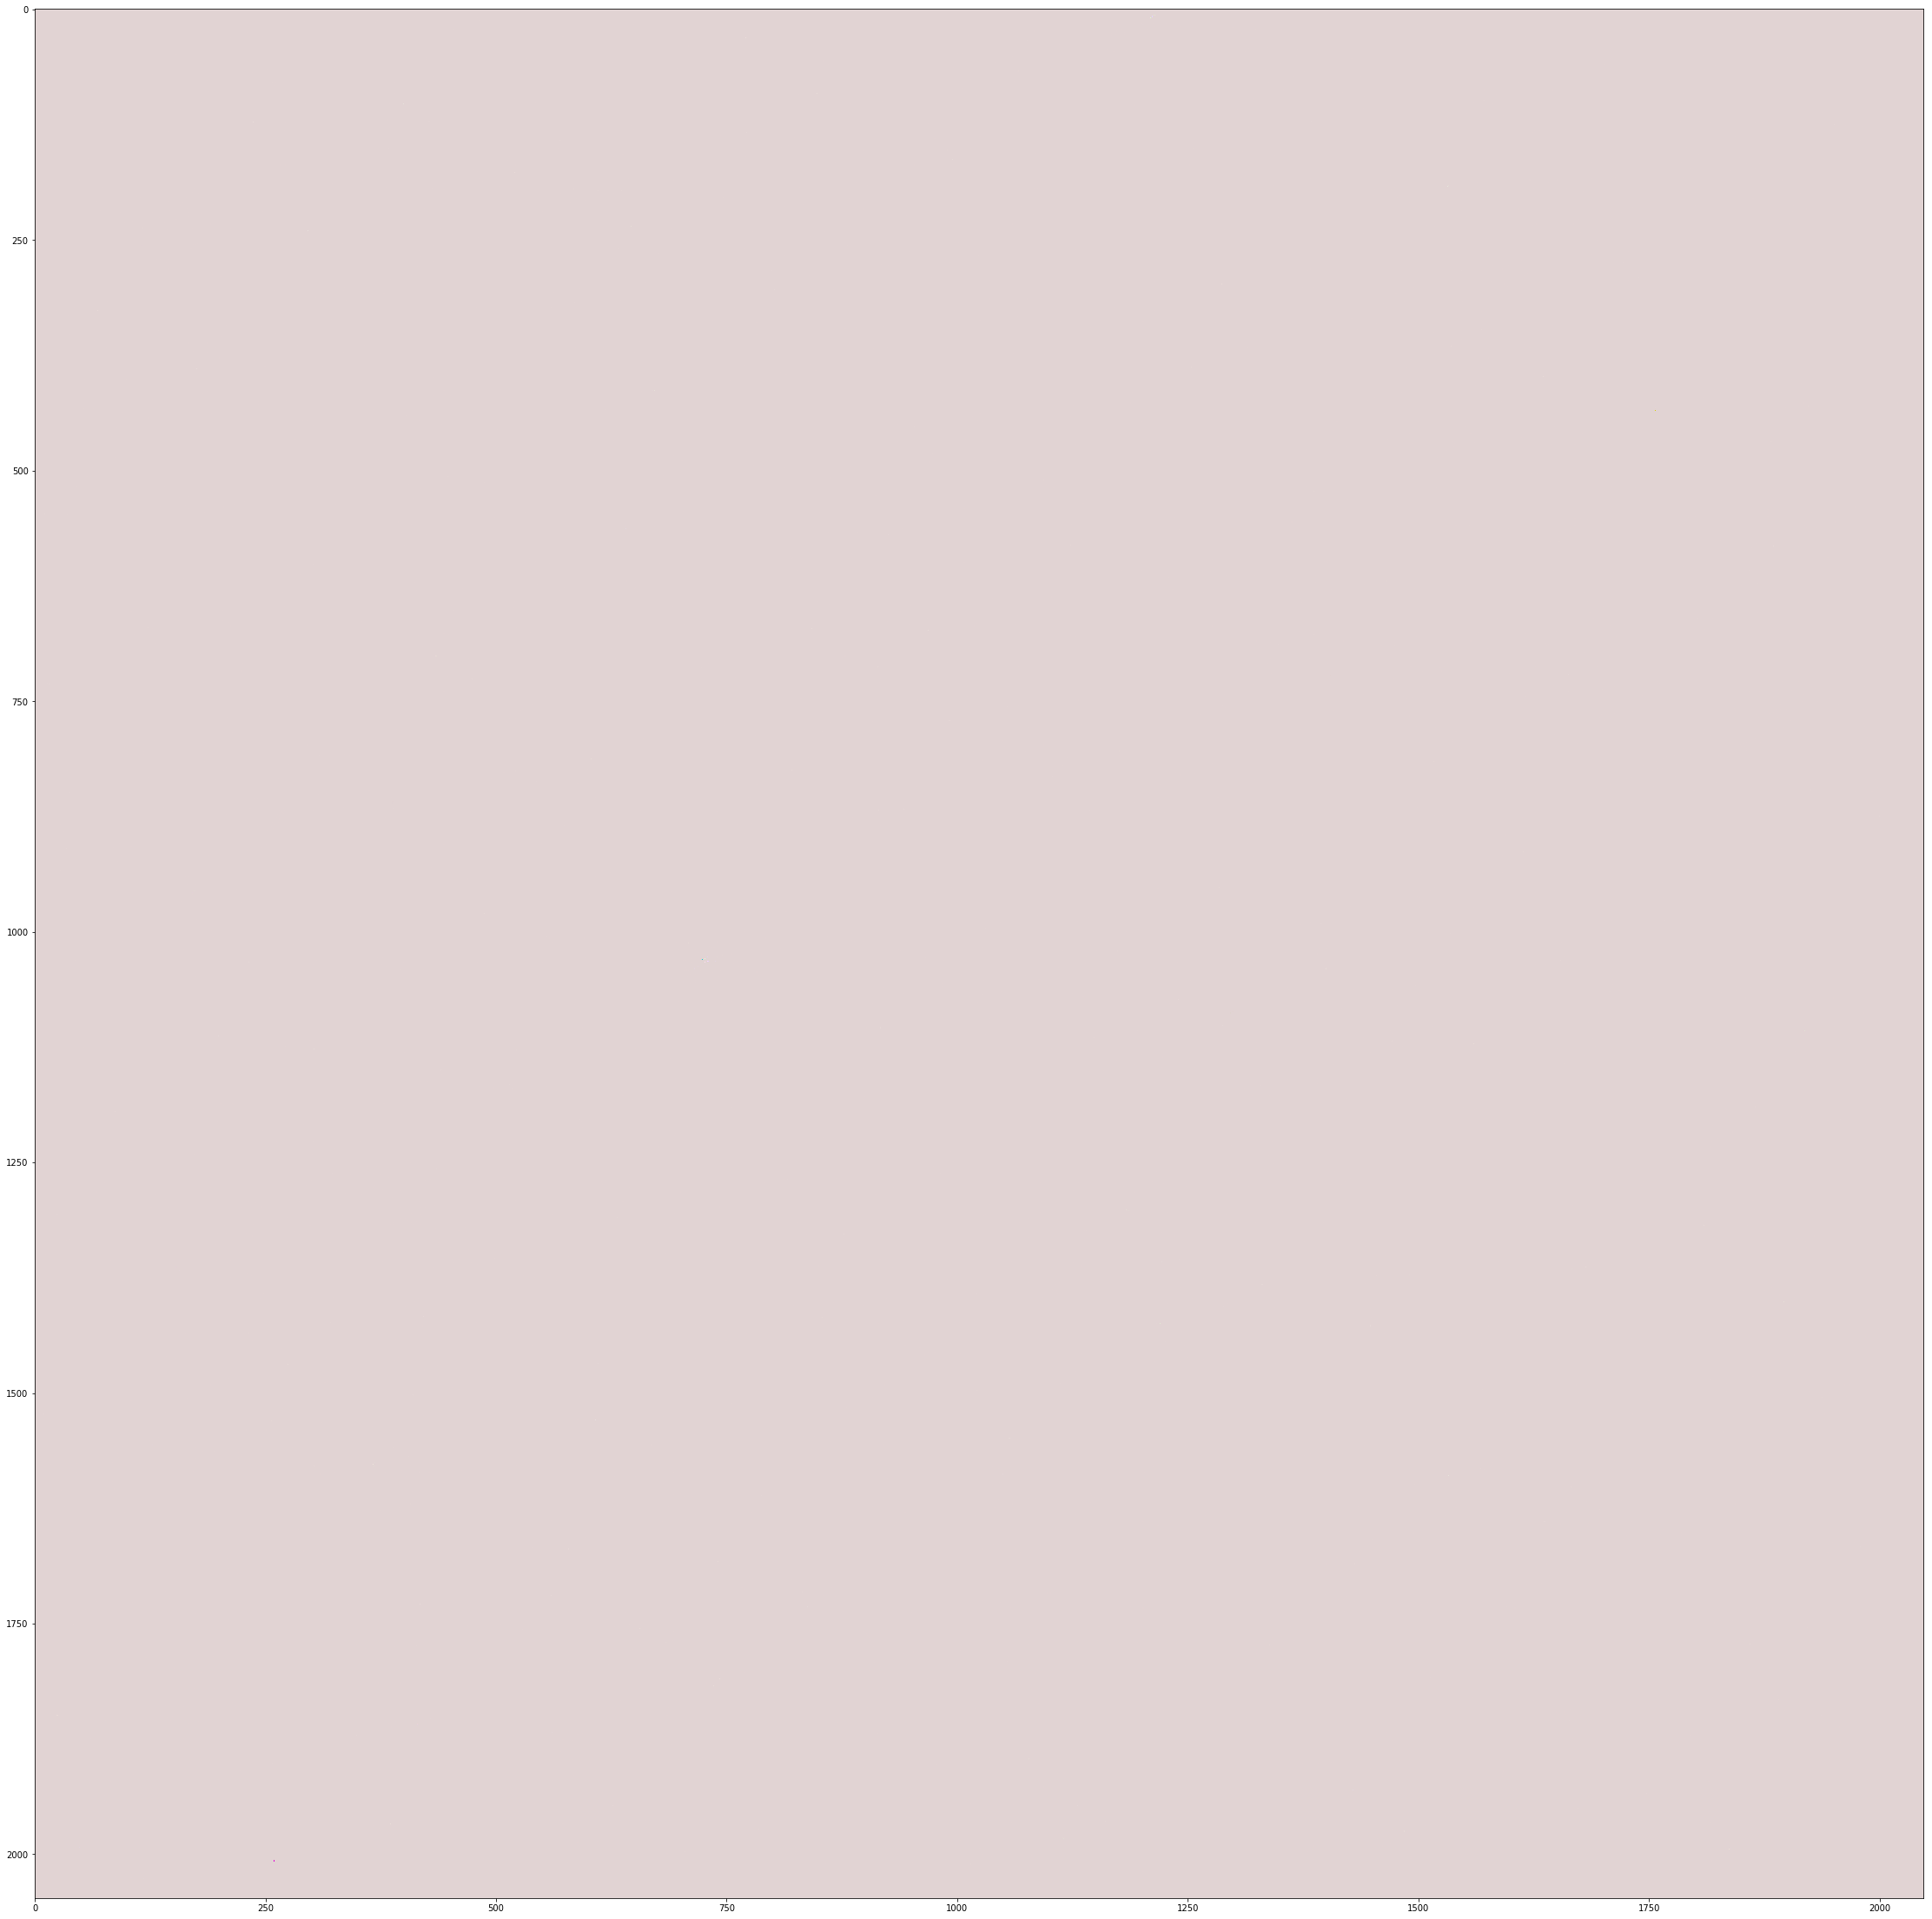

In [235]:
plt.figure(figsize=(40,40))
plt.imshow(data_nrm[:,:,:3])

In [203]:
from skimage.filters import gaussian

In [210]:
data_nrm = gaussian(data_nrm, sigma=0.51, multichannel=True)

In [222]:
data_nrm.min()

0.0

In [9]:
import pandas as pd
import numpy as np

In [10]:
data = np.load('/home/rt2122/data/check_cl/td_il5_ip0_ra227.2387_dec57.7142_sgrizy_in6.npy')
mask = np.load('/home/rt2122/data/check_cl/tm_il5_ip0_ra227.2387_dec57.7142_sm_in6.npy')
mask //= 255

In [12]:
import matplotlib.pyplot as plt

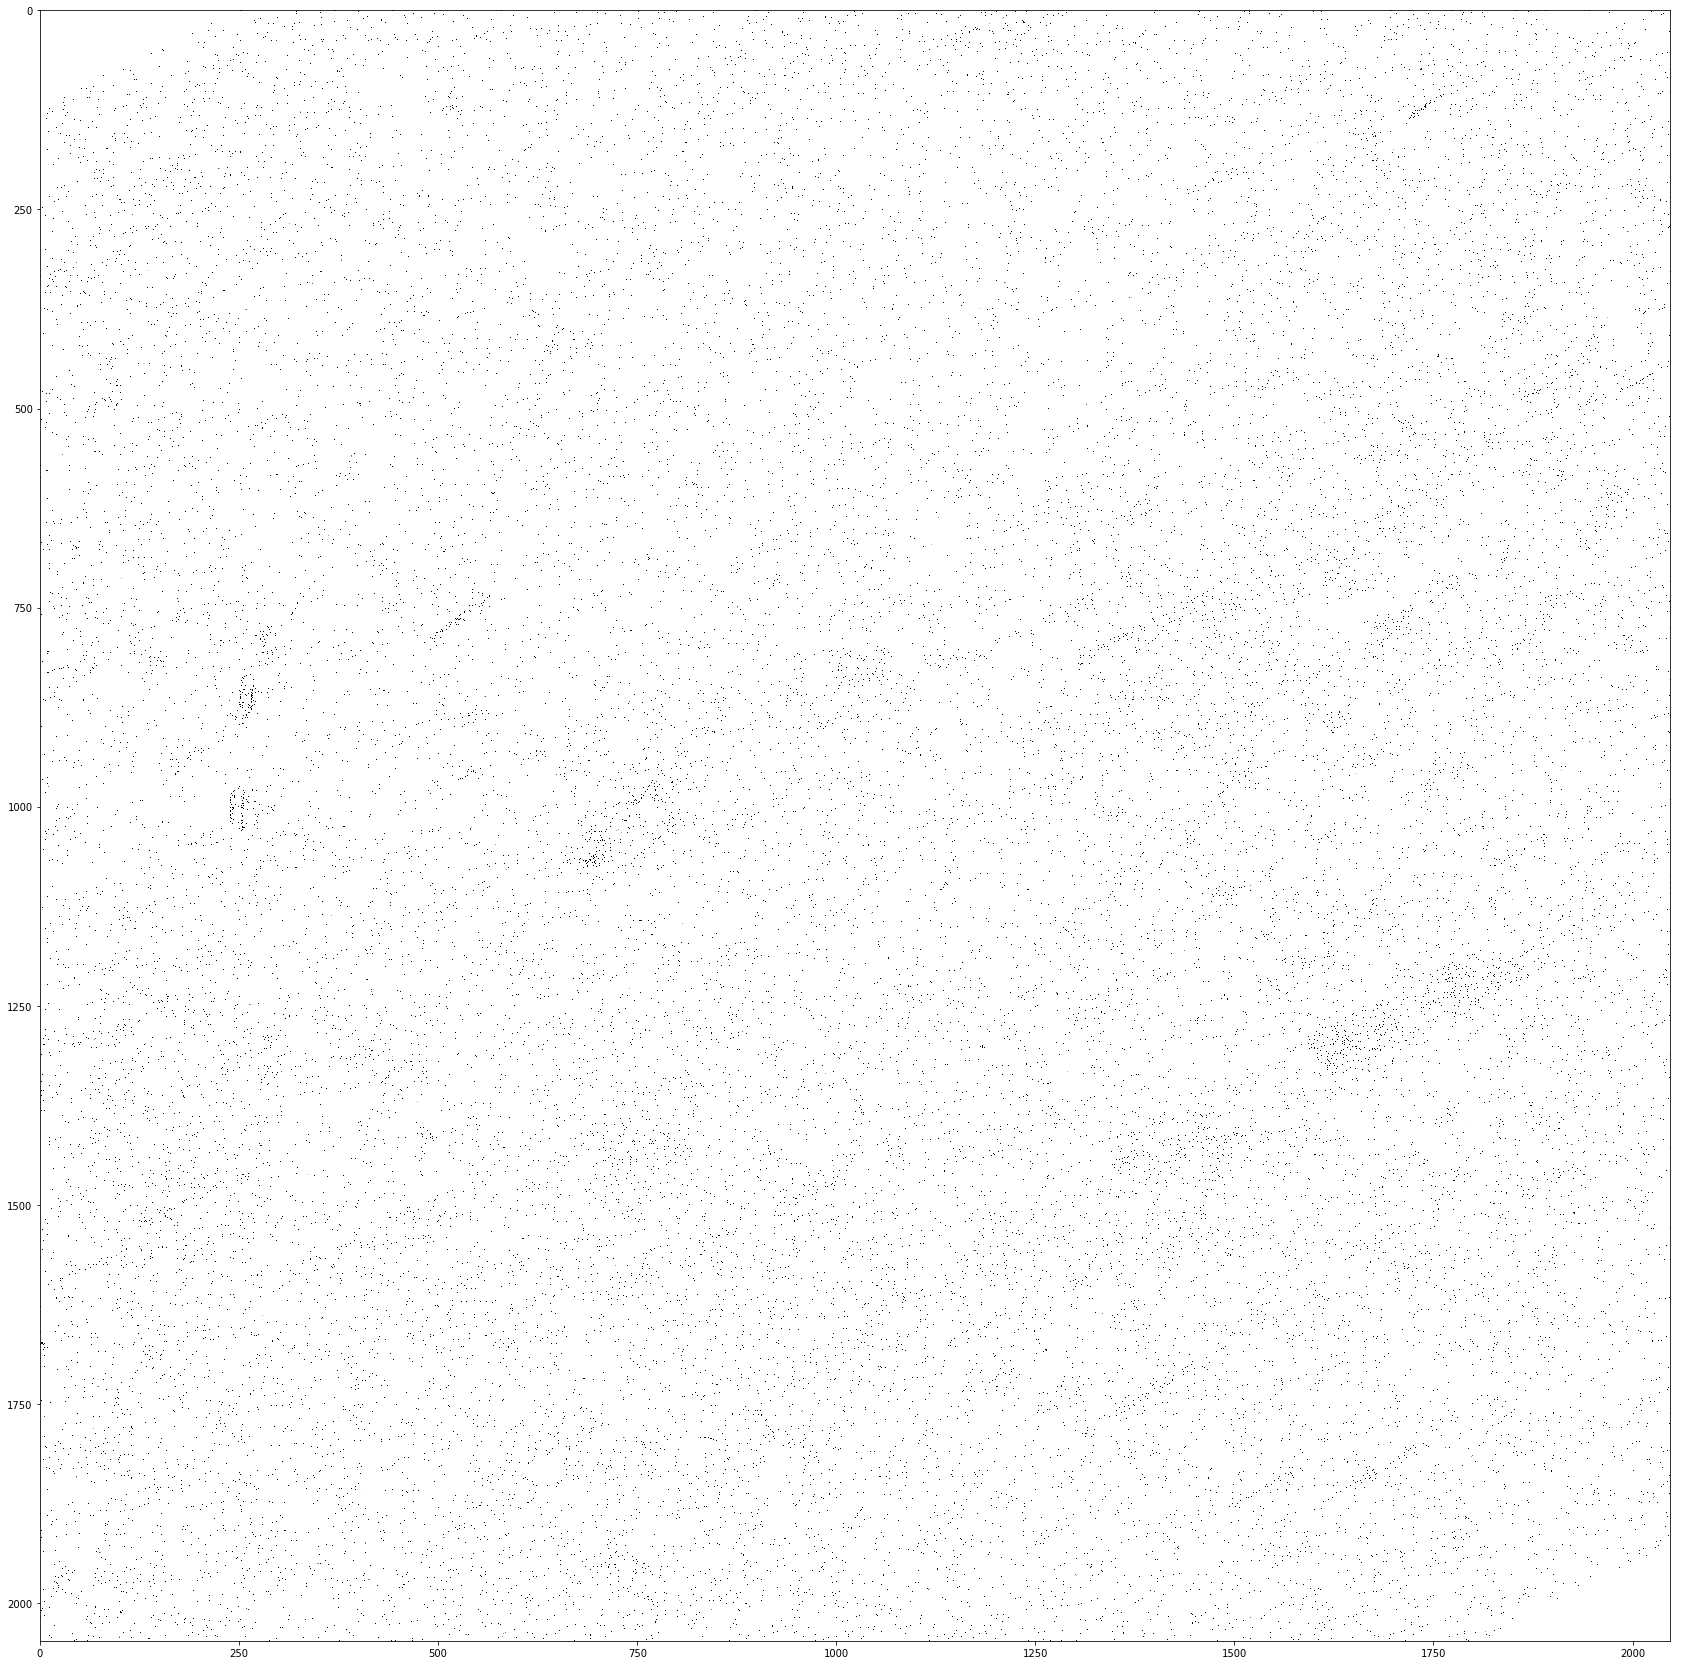

In [13]:
plt.figure(figsize=(30,30))
plt.imshow(norm(data)[:,:,:3])

In [8]:
def norm(mtx):
    s = np.copy(mtx)
    for i in range(s.shape[2]):
        s[:,:,i] -= s[:,:,i].min()
        s[:,:,i] /= s[:,:,i].max()
    s = 1 - s 
    return s

In [14]:
norm(data)

0.0 1.0


In [16]:
mask = mask.reshape(list(mask.shape) + [1])

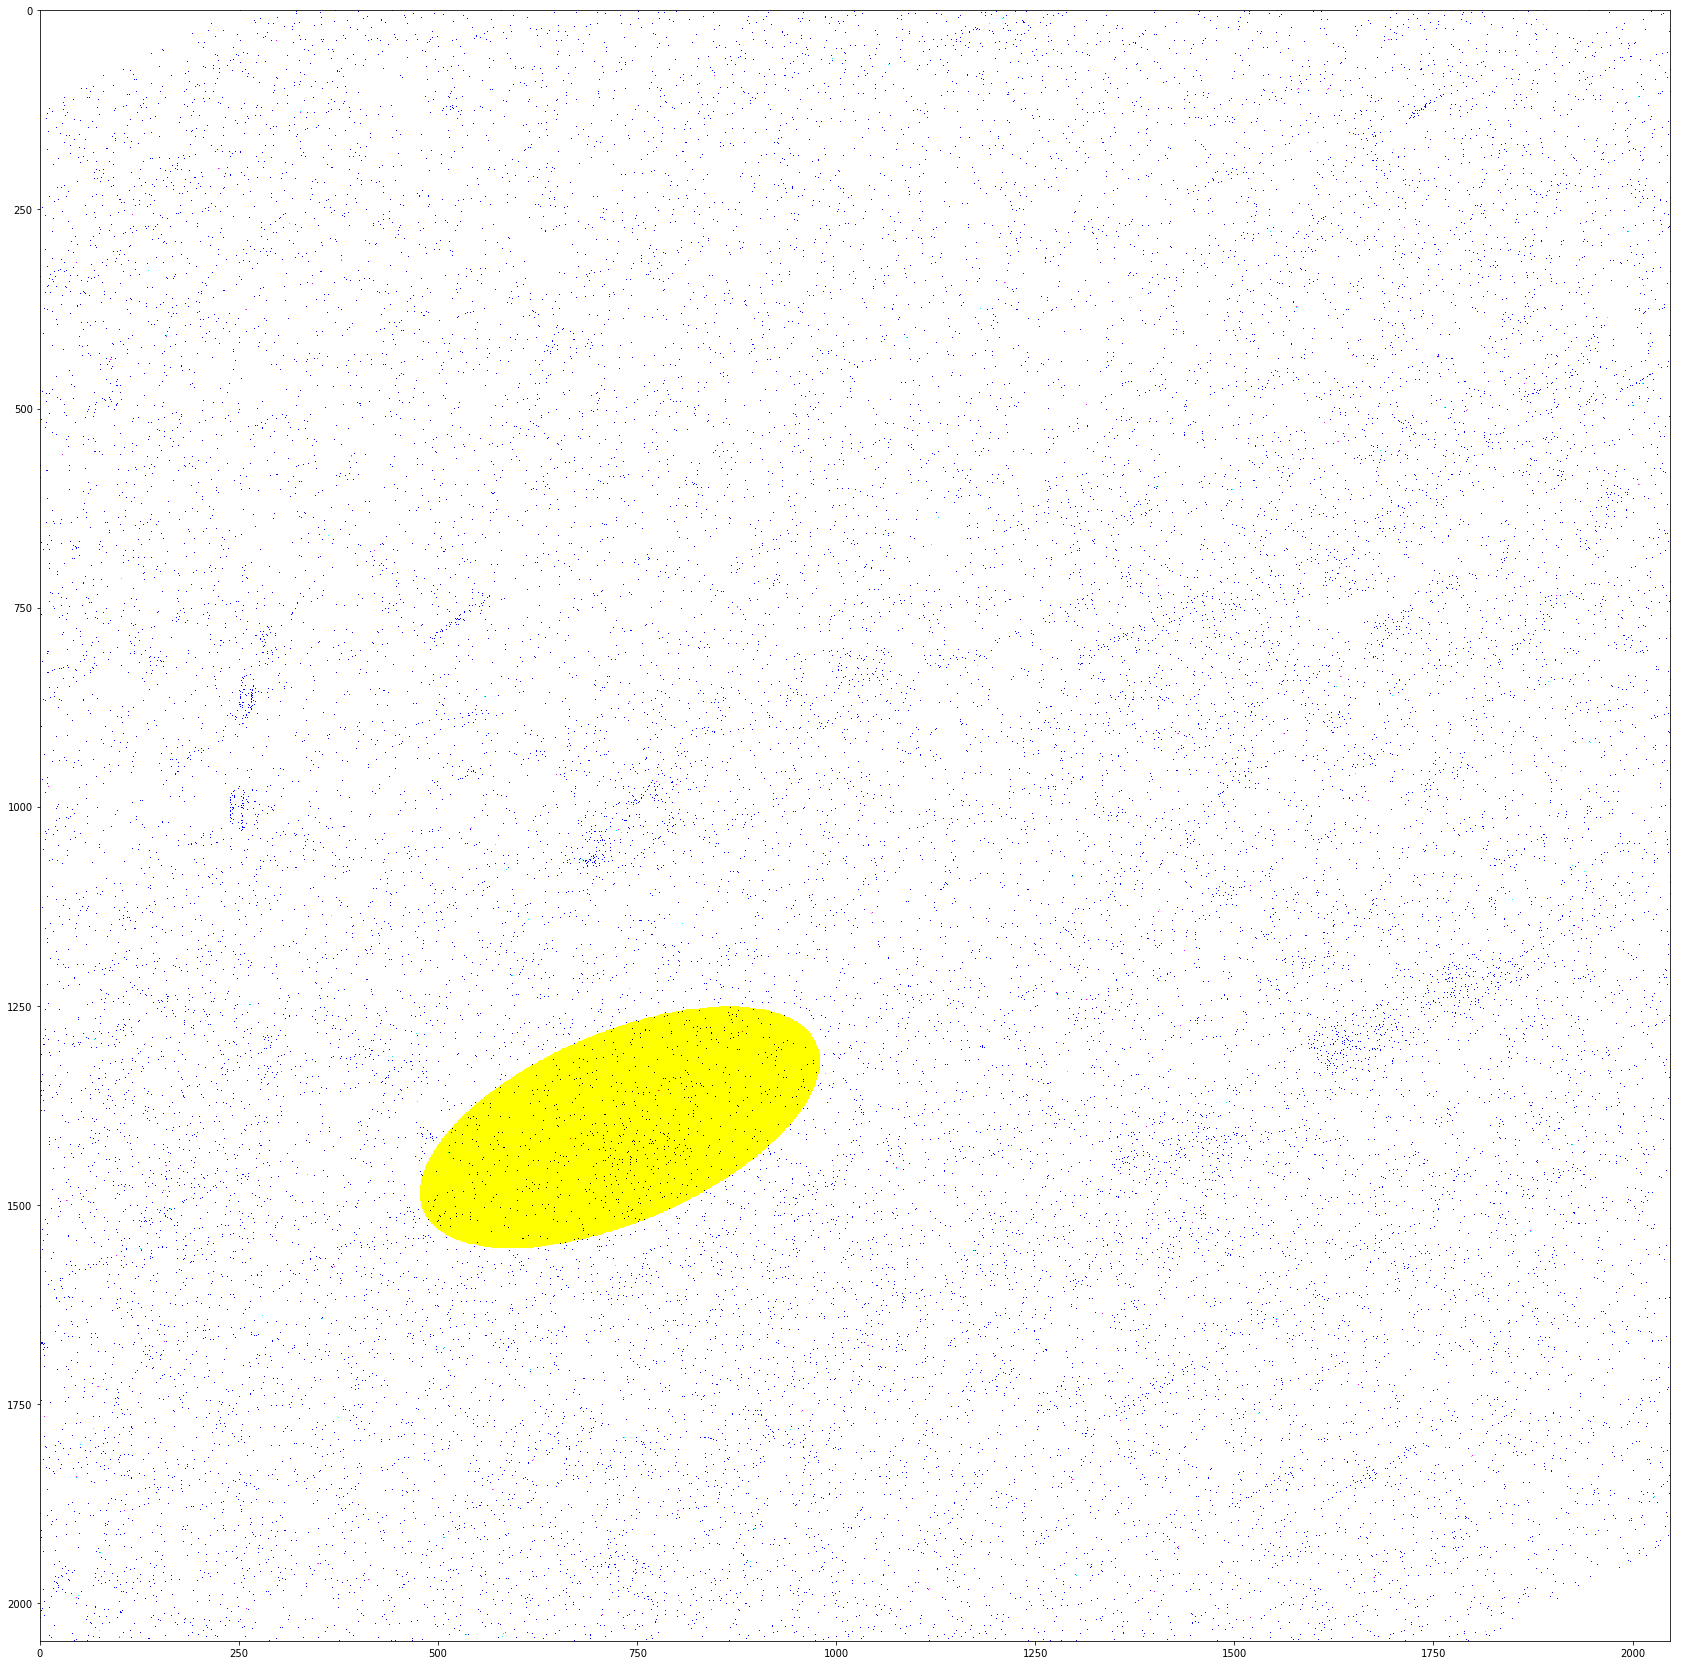

In [21]:
plt.figure(figsize=(30,30))
plt.imshow(np.dstack([norm(data[:,:,:2]), norm(mask)]))

In [18]:
mask.shape

(2048, 2048, 1)

In [20]:
mask = mask.astype(np.float32)

In [1]:
import pandas as pd

In [4]:
patch = pd.read_csv('/home/rt2122/data/check_cl/tdat_il5_ip0_ra227.2387_dec57.7142_scl_in6.csv', index_col='Unnamed: 0')
patch.index.name='index'

In [5]:
patch.head()

,objID,l,b,gPSFFlux,gKronFlux,rPSFFlux,rKronFlux,iPSFFlux,iKronFlux,zPSFFlux,zKronFlux,yPSFFlux,yKronFlux,pix
index,,,,,,,,,,,,,,
0,176242271126067080,93.234166,51.618278,9.909140e-07,NaN,0.000004,0.000004,0.000005,0.000005,0.000003,NaN,0.000003,NaN,28974663935
1,176242271241138012,93.229490,51.612912,-2.115080e-07,NaN,0.000001,NaN,0.000002,0.000001,0.000002,NaN,0.000002,NaN,28974653285
2,176242271266388756,93.229066,51.611445,1.430390e-07,NaN,0.000003,0.000003,0.000009,0.000010,0.000020,0.000024,0.000028,0.000031,28974653237
3,176242271509736722,93.214319,51.601551,3.541410e-07,NaN,0.000002,NaN,0.000002,NaN,0.000004,0.000004,0.000007,NaN,28974657651
4,176242271570427103,93.211525,51.598826,3.531840e-06,0.000003,0.000006,0.000006,0.000006,0.000007,0.000006,0.000009,0.000006,NaN,28974657668


In [6]:
import numpy as np
mtx = np.load('/home/rt2122/data/check_cl/tmtx_il5_ip0_ra227.2387_dec57.7142_in6.npy')

In [7]:
from all_p import pix2dict

In [8]:
dict_pix = pix2dict(mtx)

In [9]:
del mtx

In [32]:
def visualisation(patch, dict_pix, size, p=100):
    import numpy as np
    from skimage.draw import circle
    ans = np.zeros((size, size), dtype=np.float32)
    for i in range(patch.shape[0]):
        pix = patch['pix'].iloc[i]
        if not (pix in dict_pix):
            continue
        x, y = dict_pix[pix]
        flux = patch['iKronFlux'].iloc[i]
        if np.isnan(flux) or flux == -999:
            flux = patch['iPSFFlux'].iloc[i]
            if np.isnan(flux) or flux == -999:
                continue
        #print(x, y, p * flux)
        ans[circle(x, y, p * flux)] =1
    ans /= ans.max()
    return ans

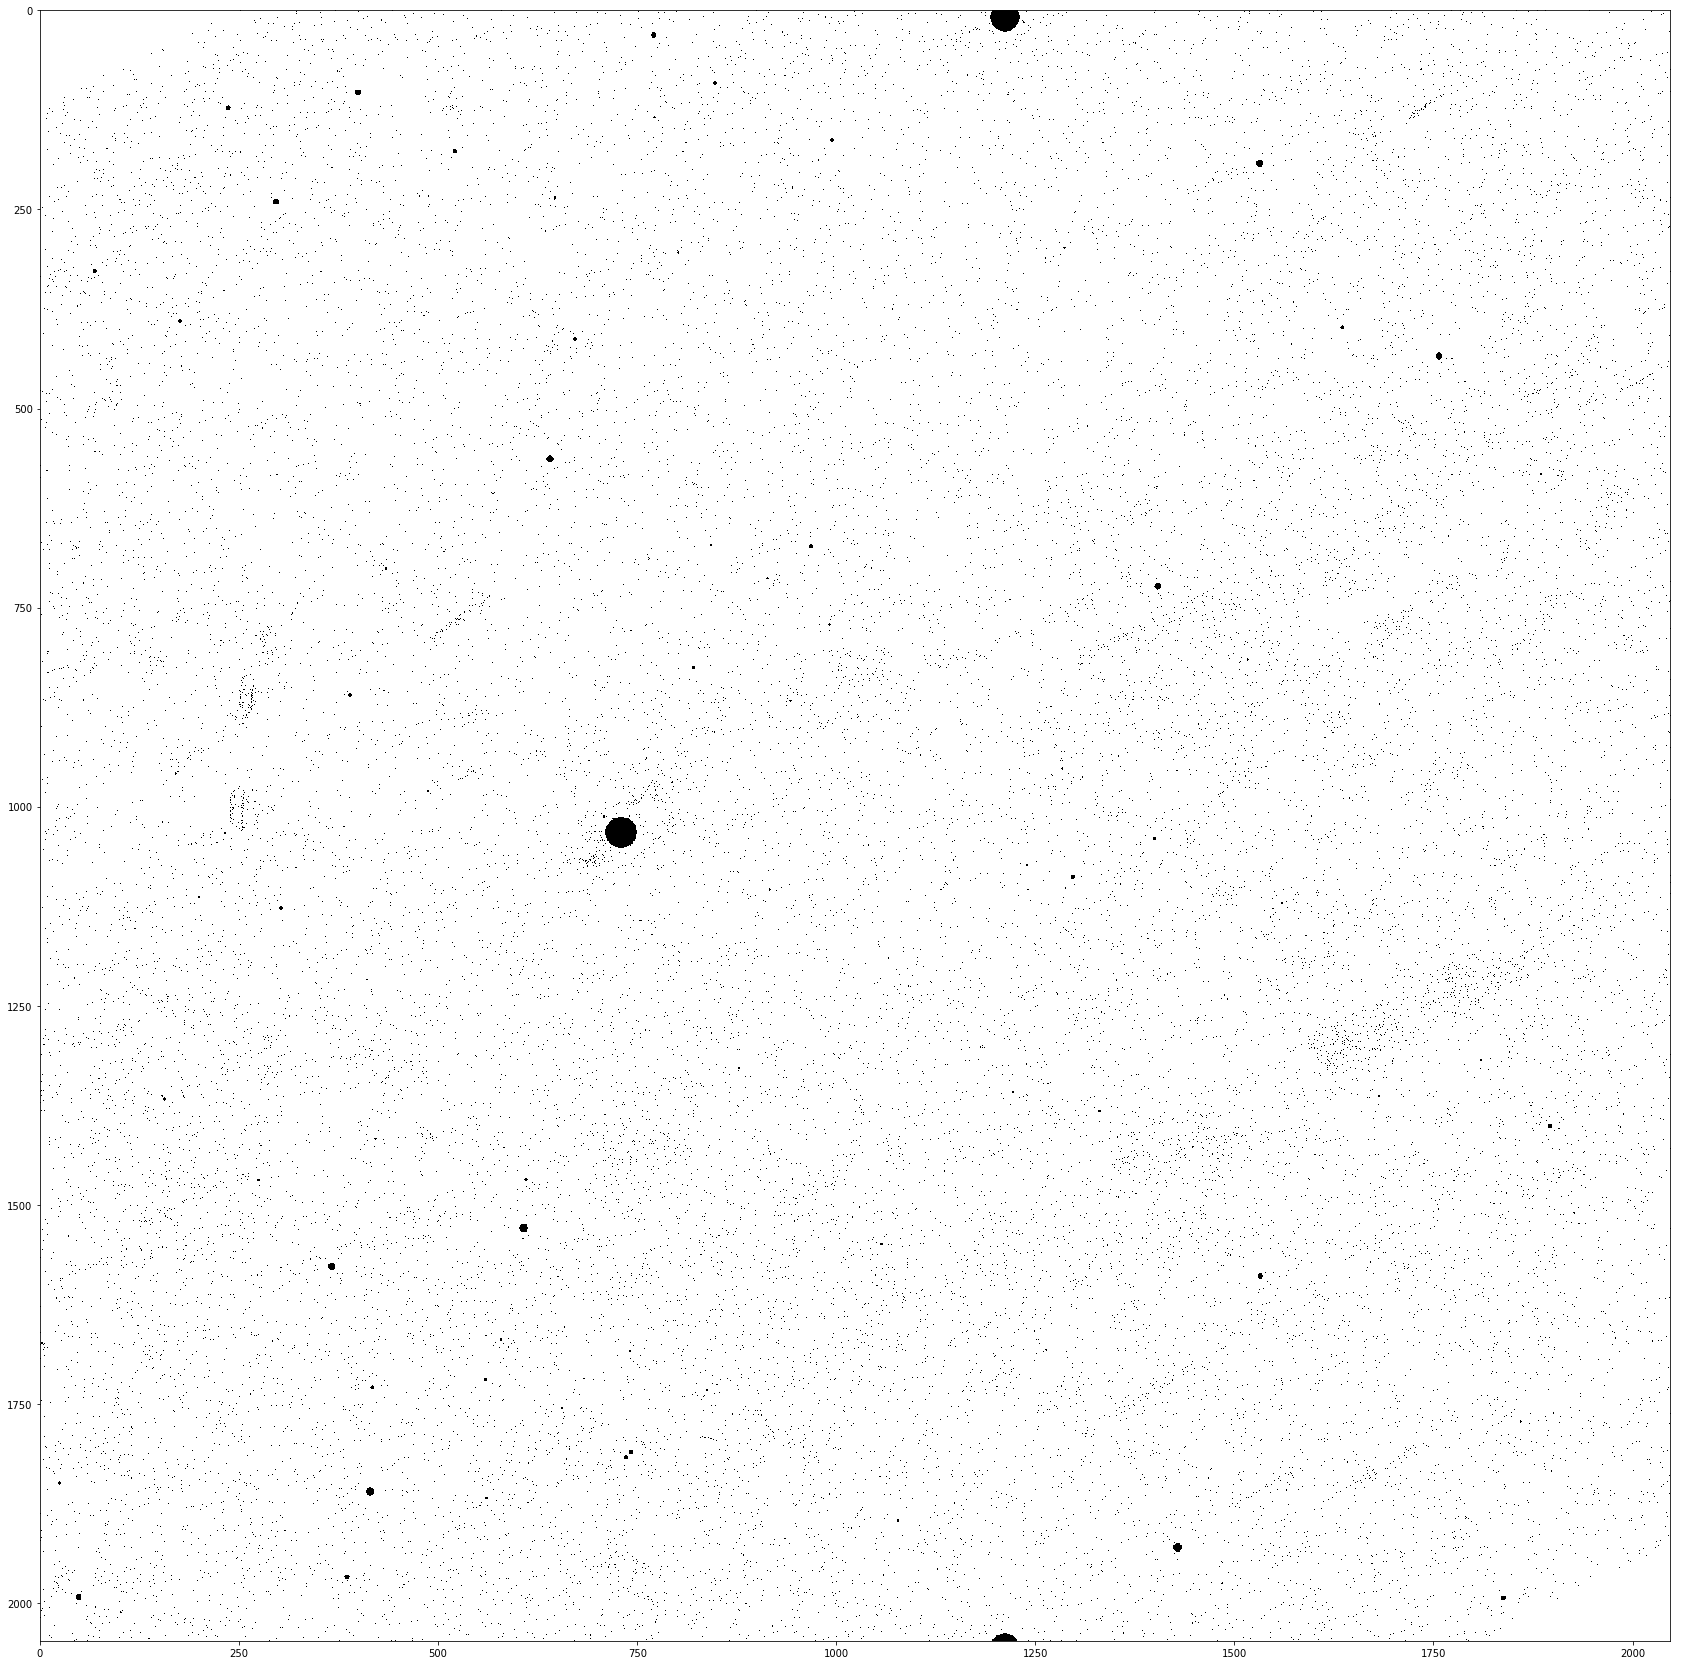

In [35]:
plt.figure(figsize=(30,30))
plt.imshow(np.dstack([1 - visualisation(patch, dict_pix, 2048)] * 3))

In [12]:
import matplotlib.pyplot as plt

In [27]:
idx = patch.loc[patch['iKronFlux'] == -999].index
patch.loc['iPSFFlux', idx] = np.nan

In [36]:
mask = np.load('/home/rt2122/data/check_cl/tm_il5_ip0_ra227.2387_dec57.7142_sm_in6.npy')

In [37]:
mask = mask.reshape(list(mask.shape) + [1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


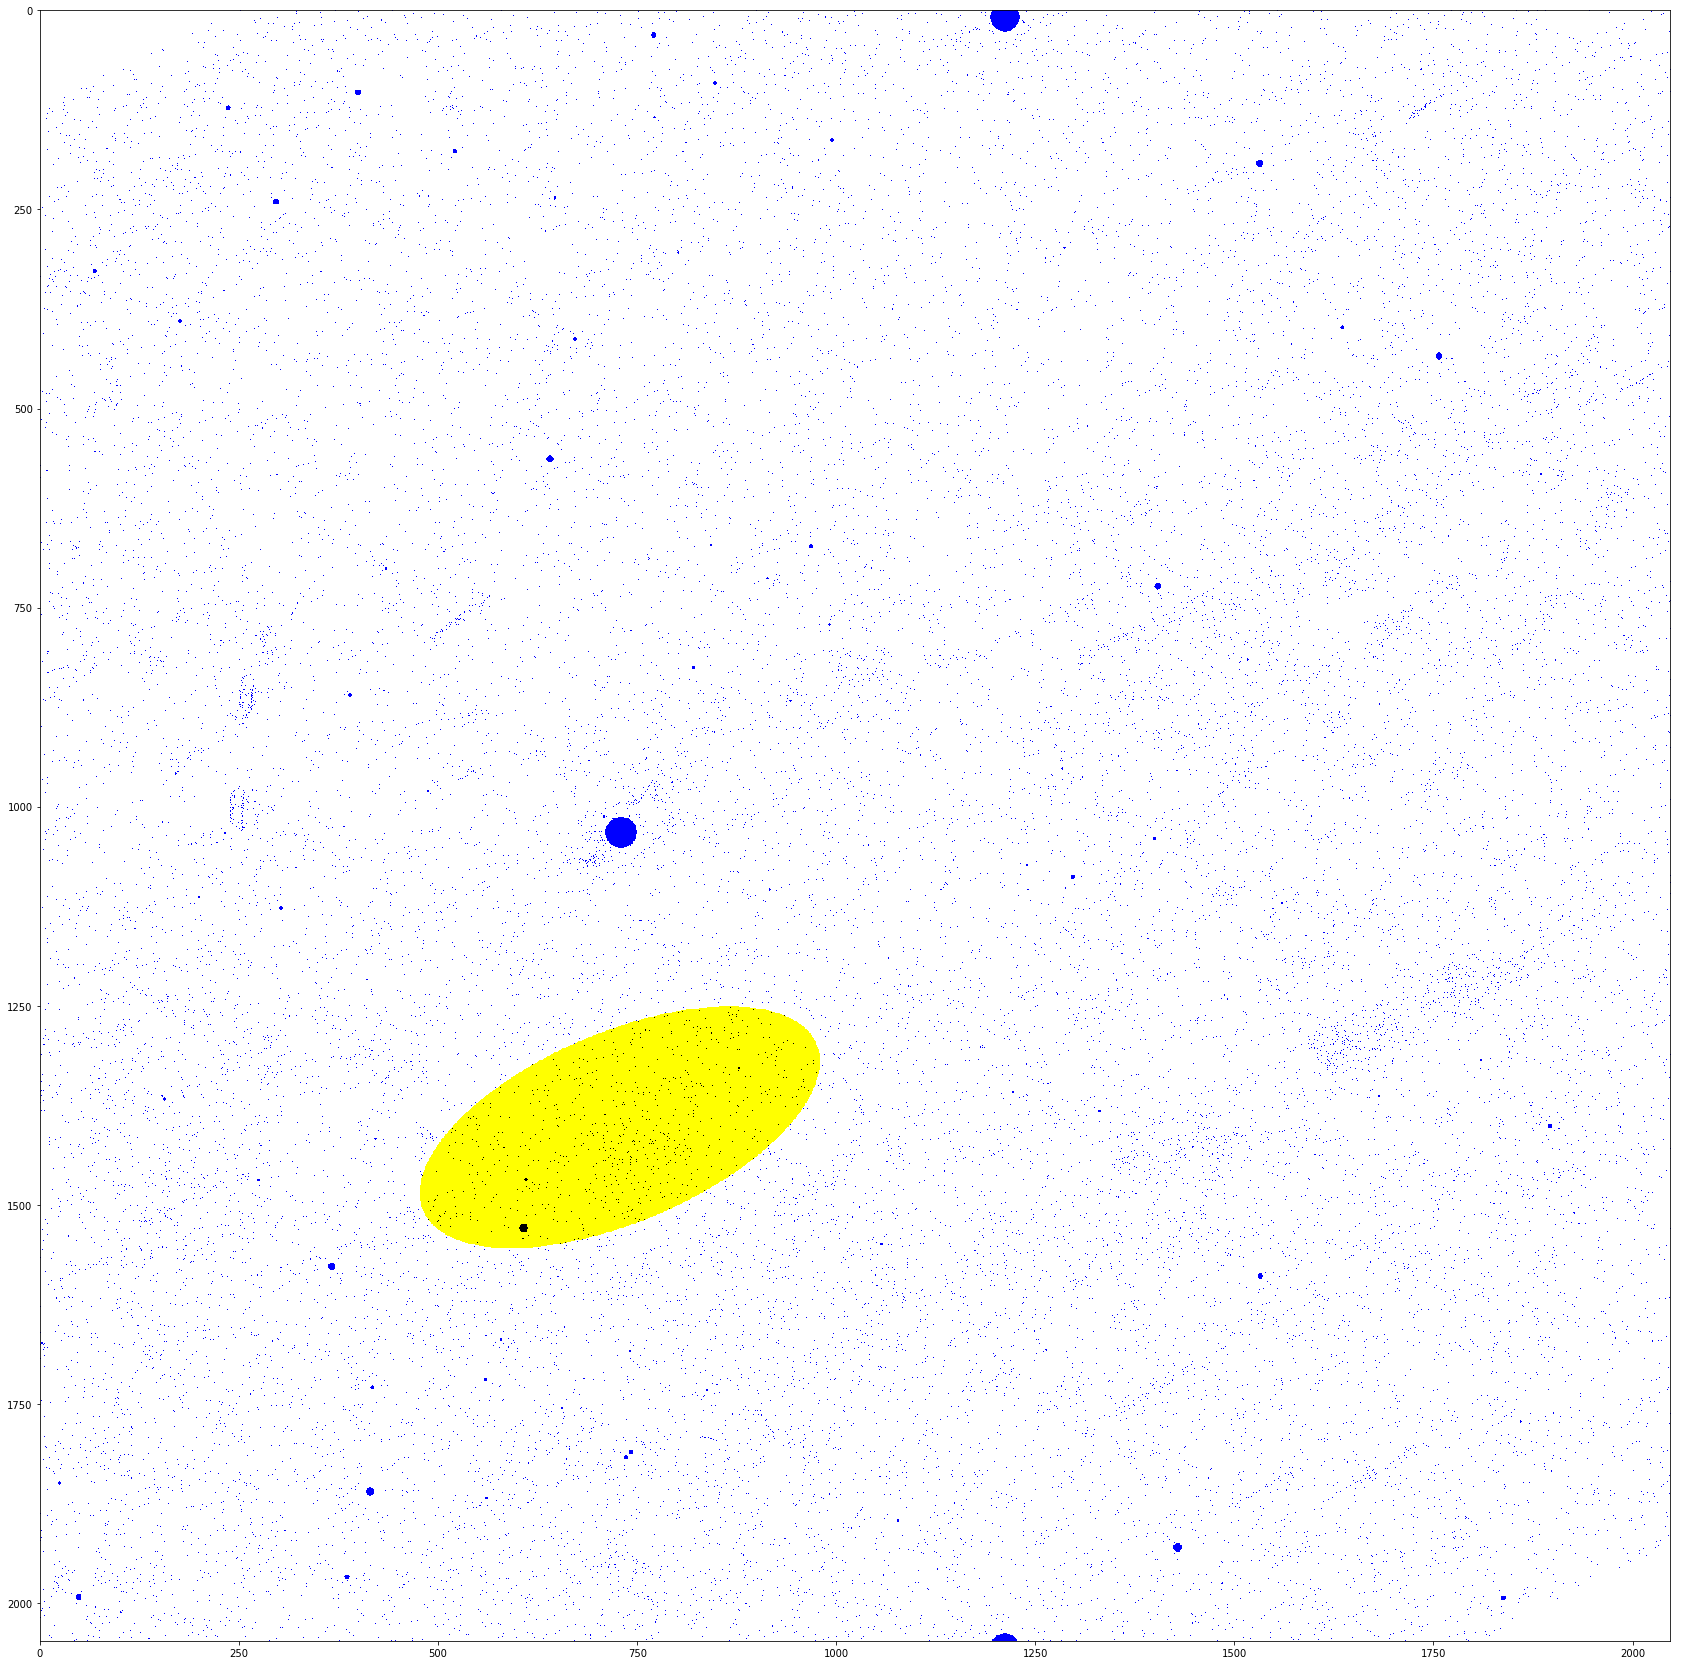

In [39]:
plt.figure(figsize=(30,30))
plt.imshow(np.dstack([1 - visualisation(patch, dict_pix, 2048)] * 2 + [1 - mask]))